相位的概念已经深入到了地震数据和信号处理中。但是其理解起来仍然比较抽象。

这篇教程中我们将重点关注与解释相关的概念。通过地震道的傅里叶变换来操作其相位，并以此来获得叠后的瞬时相位属性。

## Hilbert 变换

实信号的傅里叶变换可以得到其振幅谱和相位谱，大多数情况下我们关注的都是振幅谱，振幅谱指示了信号各个频率的能量大小。但是相位谱是同样重要的，其指示了信号能量随时间的分布。通过操作傅里叶相位我们可以改变信号的结构而保持其振幅谱不变。

Hilbert 变换是使信号完成90度相移的线性算子。Hilbert 变换与傅里叶变换息息相关，信号$\mu$的 Hilbert 变换$H$的傅里叶变换$F$表示如下：

$$
F(H(\mu))(\omega) = \sigma_{H}(\omega) \cdot F(\mu)(\omega)
$$

其中：
$$
\sigma_H(\omega) =
\begin{cases}
i \quad \text{for} \, \omega < 0 \\
0 \quad \text{for} \, \omega = 0 \\
-i \quad \text{for}\,  \omega > 0
\end{cases}
$$

欧拉方程$e^{i\alpha} = cos \alpha + i sin\alpha$

In [59]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

In [183]:
def load_simple_trace(filename):
    '''
    load a trace was exported from
    OpenDTect as a simple FIle with
    header info
    '''
    s = np.loadtxt(filename)
    s = s[2:]
    t = np.arange(0, 6001, 4)
    trace_header = s[0:2]
    return s, t, trace_header

def fftshifter(x, phase_shift_in_radians):
    '''
    Create an array to apply the coefficient to
    positive and negative frequencies appropriately
    '''
    N = len(x)
    M = np.int(np.ceil((N+1)/2))
    R0 = np.exp(1j*phase_shift_in_radians)
    R = np.empty_like(x, dtype=complex)  # 注意类型！！
    R[:M] = R0
    R[M:] = np.conj(R0)
    
    # Apply the phase shift in the frequency domain
    Xshifted = R*fftpack.fft(x)
    
    # Recover the shifted time domain signal
    y = fftpack.ifft(Xshifted).real
    return y

def ffthilbert(x):
    return fftshifter(x, -np.pi/2)

def fid_peaks(x, a):
    '''
    Detect peaks in envelope using non-maximal supression
    '''
    window_length = 3
    trace_length = x.size
    half_length = np.int(np.ceil((window_length - 1)/2))
    y = np.zeros_like(x)
    ya = np.nan * np.ones_like(x)
    for n in range(half_length+1, trace_length - half_length):
        local_max = np.max(x[n-half_length:n+half_length+1])
        if x[n] >= local_max:
            y[n] = x[n]
            ya[n] = a[n]
            
    return y, ya
    

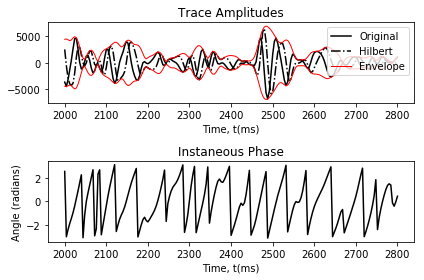

In [184]:
# Load a seismic trace
s, t, _ = load_simple_trace('data/trace_il1190_xl1155.trace')
trace_length = t.size

# Compute the analytic trace
z = s + 1j*ffthilbert(s)
envelope = np.abs(z)
phase = np.angle(z)

# Plot the complex trace
plot_range = range(500, 701) # select 1s window for plotting
tshort = t[plot_range]

fig, ax = plt.subplots(2, 1)
ax[0].plot(tshort, np.real(z[plot_range]), color='k', label='Original')
ax[0].plot(tshort, np.imag(z[plot_range]), color='k', linestyle='-.', label='Hilbert')
ax[0].plot(tshort, envelope[plot_range], color='r', linewidth=1, label='Envelope')
ax[0].plot(tshort, -envelope[plot_range], color='r', linewidth=1)
ax[0].set_title("Trace Amplitudes")
ax[0].set_xlabel("Time, t(ms)")
ax[0].legend(loc='upper right')

ax[1].plot(tshort, phase[plot_range], color='k')
ax[1].set_title("Instaneous Phase")
ax[1].set_xlabel("Time, t(ms)")
ax[1].set_ylabel("Angle (radians)")

fig.tight_layout()

# Detect peaks in envelope using non-maximal supression


## 地震数据测试


In [290]:
from obspy.io.segy.core import _read_segy



def extract_data(filename):
    '''
    Extract 2D data from obspy stream object
    '''
    st = _read_segy(filename)
    trace_number = len(st)
    samples = len(st[0])
    data = np.zeros((samples, trace_number), dtype=np.float32)
    for i, trace in enumerate(st):
        data[:, i] = trace.data
        
    return data

def complex_attributes_section(section):
    '''
    
    '''
    sz = section.shape
    hilbert = np.zeros(sz, dtype=np.float32)
    for i in range(sz[1]):  # for every trace
        hilbert[:, i] = fftshifter(section[:, i], -np.pi/2)
        
    # form a complex version of the section
    z = section + 1j * hilbert
    envelope = np.sqrt(np.real(z)**2 + np.imag(z)**2)
    phase = -np.angle(z)
    return z, envelope, phase

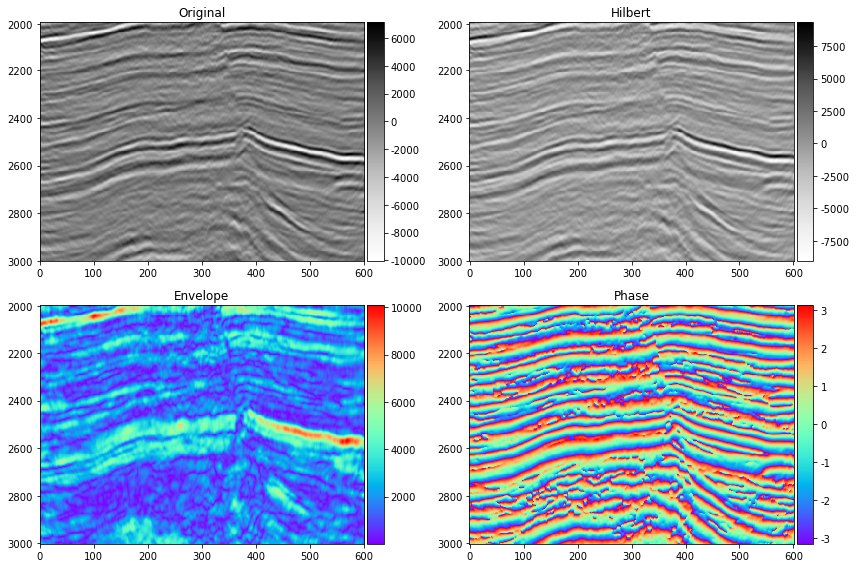

In [317]:
data = extract_data('data/penobscot_xl1155.sgy')
z, envelope, phase = complex_attributes_section(data)

plot_range = range(500, 751)  # select 1s window for plotting

z[:, 190] = 6500 + 1j*8000

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
yticks = np.array([1, 50, 100, 150, 200, 250])
ytickslabel = np.arange(2000, 3001, 200)


im1 = ax1.imshow(np.fliplr(z[plot_range, :].real), cmap=plt.cm.Greys, aspect='auto') # the original seismic section
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytickslabel)
ax1.set_title('Original')
# Create divider for existing axes instance
divider1 = make_axes_locatable(ax1)
# Append axes to the right of ax3, with 20% width of ax3
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar1 = plt.colorbar(im1, cax=cax1, format="%d")

im2 = ax2.imshow(np.fliplr(z[plot_range, :].imag), cmap=plt.cm.Greys, aspect='auto')
ax2.set_yticks(yticks)
ax2.set_yticklabels(ytickslabel)
ax2.set_title('Hilbert')
# Create divider for existing axes instance
divider2 = make_axes_locatable(ax2)
# Append axes to the right of ax3, with 20% width of ax3
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar2 = plt.colorbar(im2, cax=cax2, format="%d")


im3 = ax3.imshow(np.fliplr(envelope[plot_range, :]), cmap=plt.cm.rainbow, aspect='auto')
ax3.set_yticks(yticks)
ax3.set_yticklabels(ytickslabel)
ax3.set_title('Envelope')
# Create divider for existing axes instance
divider3 = make_axes_locatable(ax3)
# Append axes to the right of ax3, with 20% width of ax3
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar3 = plt.colorbar(im3, cax=cax3, format="%d")


im4 = ax4.imshow(np.fliplr(phase[plot_range, :]), cmap=plt.cm.rainbow, aspect='auto')
ax4.set_yticks(yticks)
ax4.set_yticklabels(ytickslabel)
ax4.set_title('Phase')
# Create divider for existing axes instance
divider4 = make_axes_locatable(ax4)
# Append axes to the right of ax3, with 20% width of ax3
cax4 = divider4.append_axes("right", size="5%", pad=0.05)
# Create colorbar in the appended axes
# Tick locations can be set with the kwarg `ticks`
# and the format of the ticklabels with kwarg `format`
cbar4 = plt.colorbar(im4, cax=cax4, format="%d")

fig.tight_layout()